In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import itertools

# Загружаем данные

In [2]:
df = pd.read_csv('yellow_tripdata_2016-05.csv')

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


# Удаляем данные с продолжительностью 0

In [4]:
df.drop(df[df['tpep_pickup_datetime'] == df['tpep_dropoff_datetime']].index, inplace=True)

# Удаляем данные с кол-вом пассажиров 0

In [5]:
df.drop(df[df['passenger_count'] == 0].index, inplace=True)

# Удаляем данные с расстоянием поездки 0

In [6]:
df.drop(df[df['trip_distance'] == 0].index, inplace=True)

# Удаляем данные, начало поездки не в Нью Йорке

In [7]:
out_of_ny = (df['pickup_longitude'] > -73.70001) | (df['pickup_longitude'] < -74.25559) | \
            (df['pickup_latitude'] > 40.91553) | (df['pickup_latitude'] < 40.49612)
df.drop(df[out_of_ny].index, inplace=True)

In [8]:
df.shape

(11626521, 19)

# Формируем дополнительные поля hour и region

In [9]:
min_longitude = -74.25559
max_longitude = -73.70001
min_latitude = 40.49612
max_latitude = 40.91553
step_longitude = (max_longitude - min_longitude) / 50
step_latitude = (max_latitude - min_latitude) / 50

In [14]:
def calculate_region(longitude, latitude):
    y = np.floor((longitude - min_longitude) / step_longitude)
    x = np.floor((latitude - min_latitude) / step_latitude)
    return (y * 50 + x + 1).astype(int)

In [15]:
def get_hour(datetime):
    return (pd.to_datetime(datetime) - pd.datetime(1970, 1, 1)).dt.total_seconds() / 3600

In [16]:
df['hour'] = get_hour(df['tpep_pickup_datetime'])

In [19]:
df['region'] = calculate_region(df['pickup_longitude'], df['pickup_latitude'])

In [20]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,region
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,...,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,406128.0,1233
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,...,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,406128.0,1180
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,...,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,406128.0,1180
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,...,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,406128.0,1173
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,...,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,406128.0,1130


In [21]:
min_hour = int(get_hour(pd.Series('2016-05-01'))[0])
max_hour = int(get_hour(pd.Series('2016-06-01'))[0])

In [22]:
statistic, xedges, yedges, binnumber = stats.binned_statistic_2d(
    df.region, 
    df.hour, 
    None, 
    statistic='count', 
    bins=[xrange(1, 2502), xrange(min_hour, max_hour + 1)])

# Составляем финальный датафрейм

In [23]:
rows = itertools.product(xrange(1, 2501), xrange(min_hour, max_hour))
final_df = pd.DataFrame(list(rows))
final_df.columns = ['region', 'hour']
final_df['counts'] = statistic.ravel()
final_df['counts'] = final_df['counts'].astype(int)
final_df['hour'] = pd.to_datetime(final_df['hour'] * 3600, unit='s')

In [24]:
final_df.head()

,region,hour,counts
0,1,2016-05-01 00:00:00,0
1,1,2016-05-01 01:00:00,0
2,1,2016-05-01 02:00:00,0
3,1,2016-05-01 03:00:00,0
4,1,2016-05-01 04:00:00,0


# Координаты Empire State Building

In [25]:
esb_longitude = -73.9857012
esb_latitude = 40.7488006
region = calculate_region(esb_longitude, esb_latitude)

In [26]:
region

1231

In [27]:
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline

In [29]:
esb_counts = final_df[final_df['region'] == 1231][['hour', 'counts']]

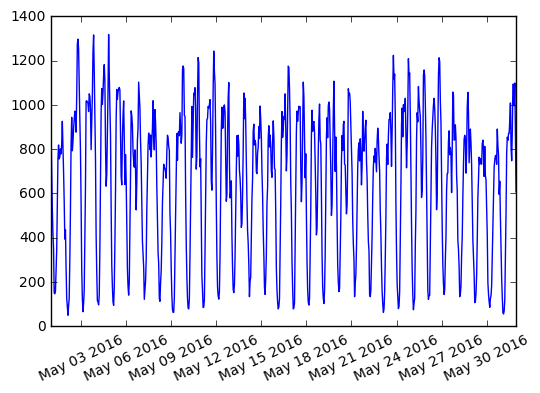

In [30]:
plt.xticks(rotation=25)
plt.plot(esb_counts.hour, esb_counts.counts)

# Кол-во записей с кол-вом поездок равным нулю

In [31]:
sum(final_df['counts'] == 0)

1718238